In [2]:
%%capture
!sudo apt-get install poppler-utils 
!sudo apt-get install tesseract-ocr-eng 

In [3]:
%%capture
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2img
!pip install "layoutparser[ocr]"

In [4]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [5]:
!pip uninstall PIL
!pip uninstall Pillow
!pip install Pillow

Found existing installation: Pillow 9.2.0
Uninstalling Pillow-9.2.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-9.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-27ef11b8.so.6.18.3
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libharfbuzz-aa5f3c5c.so.0.40401.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-3e290cba.so.62.3.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-1e643a89.so.2.0.13
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-d540a118.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-fca9bf24.so.2.5.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-52f22300.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-3a0dc242.so.5.8.0
    /usr/local/lib/python3.7/dist-packages/Pillo

In [1]:
import pdf2image
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
import torch

In [2]:
pdf_file= '/content/CRT_CH5010_CP.pdf' 
img = np.asarray(pdf2image.convert_from_path(pdf_file)[0])

config.yaml?dl=1: 8.19kB [00:01, 4.32kB/s]
model_final.pth?dl=1: 856MB [00:40, 21.3MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-d

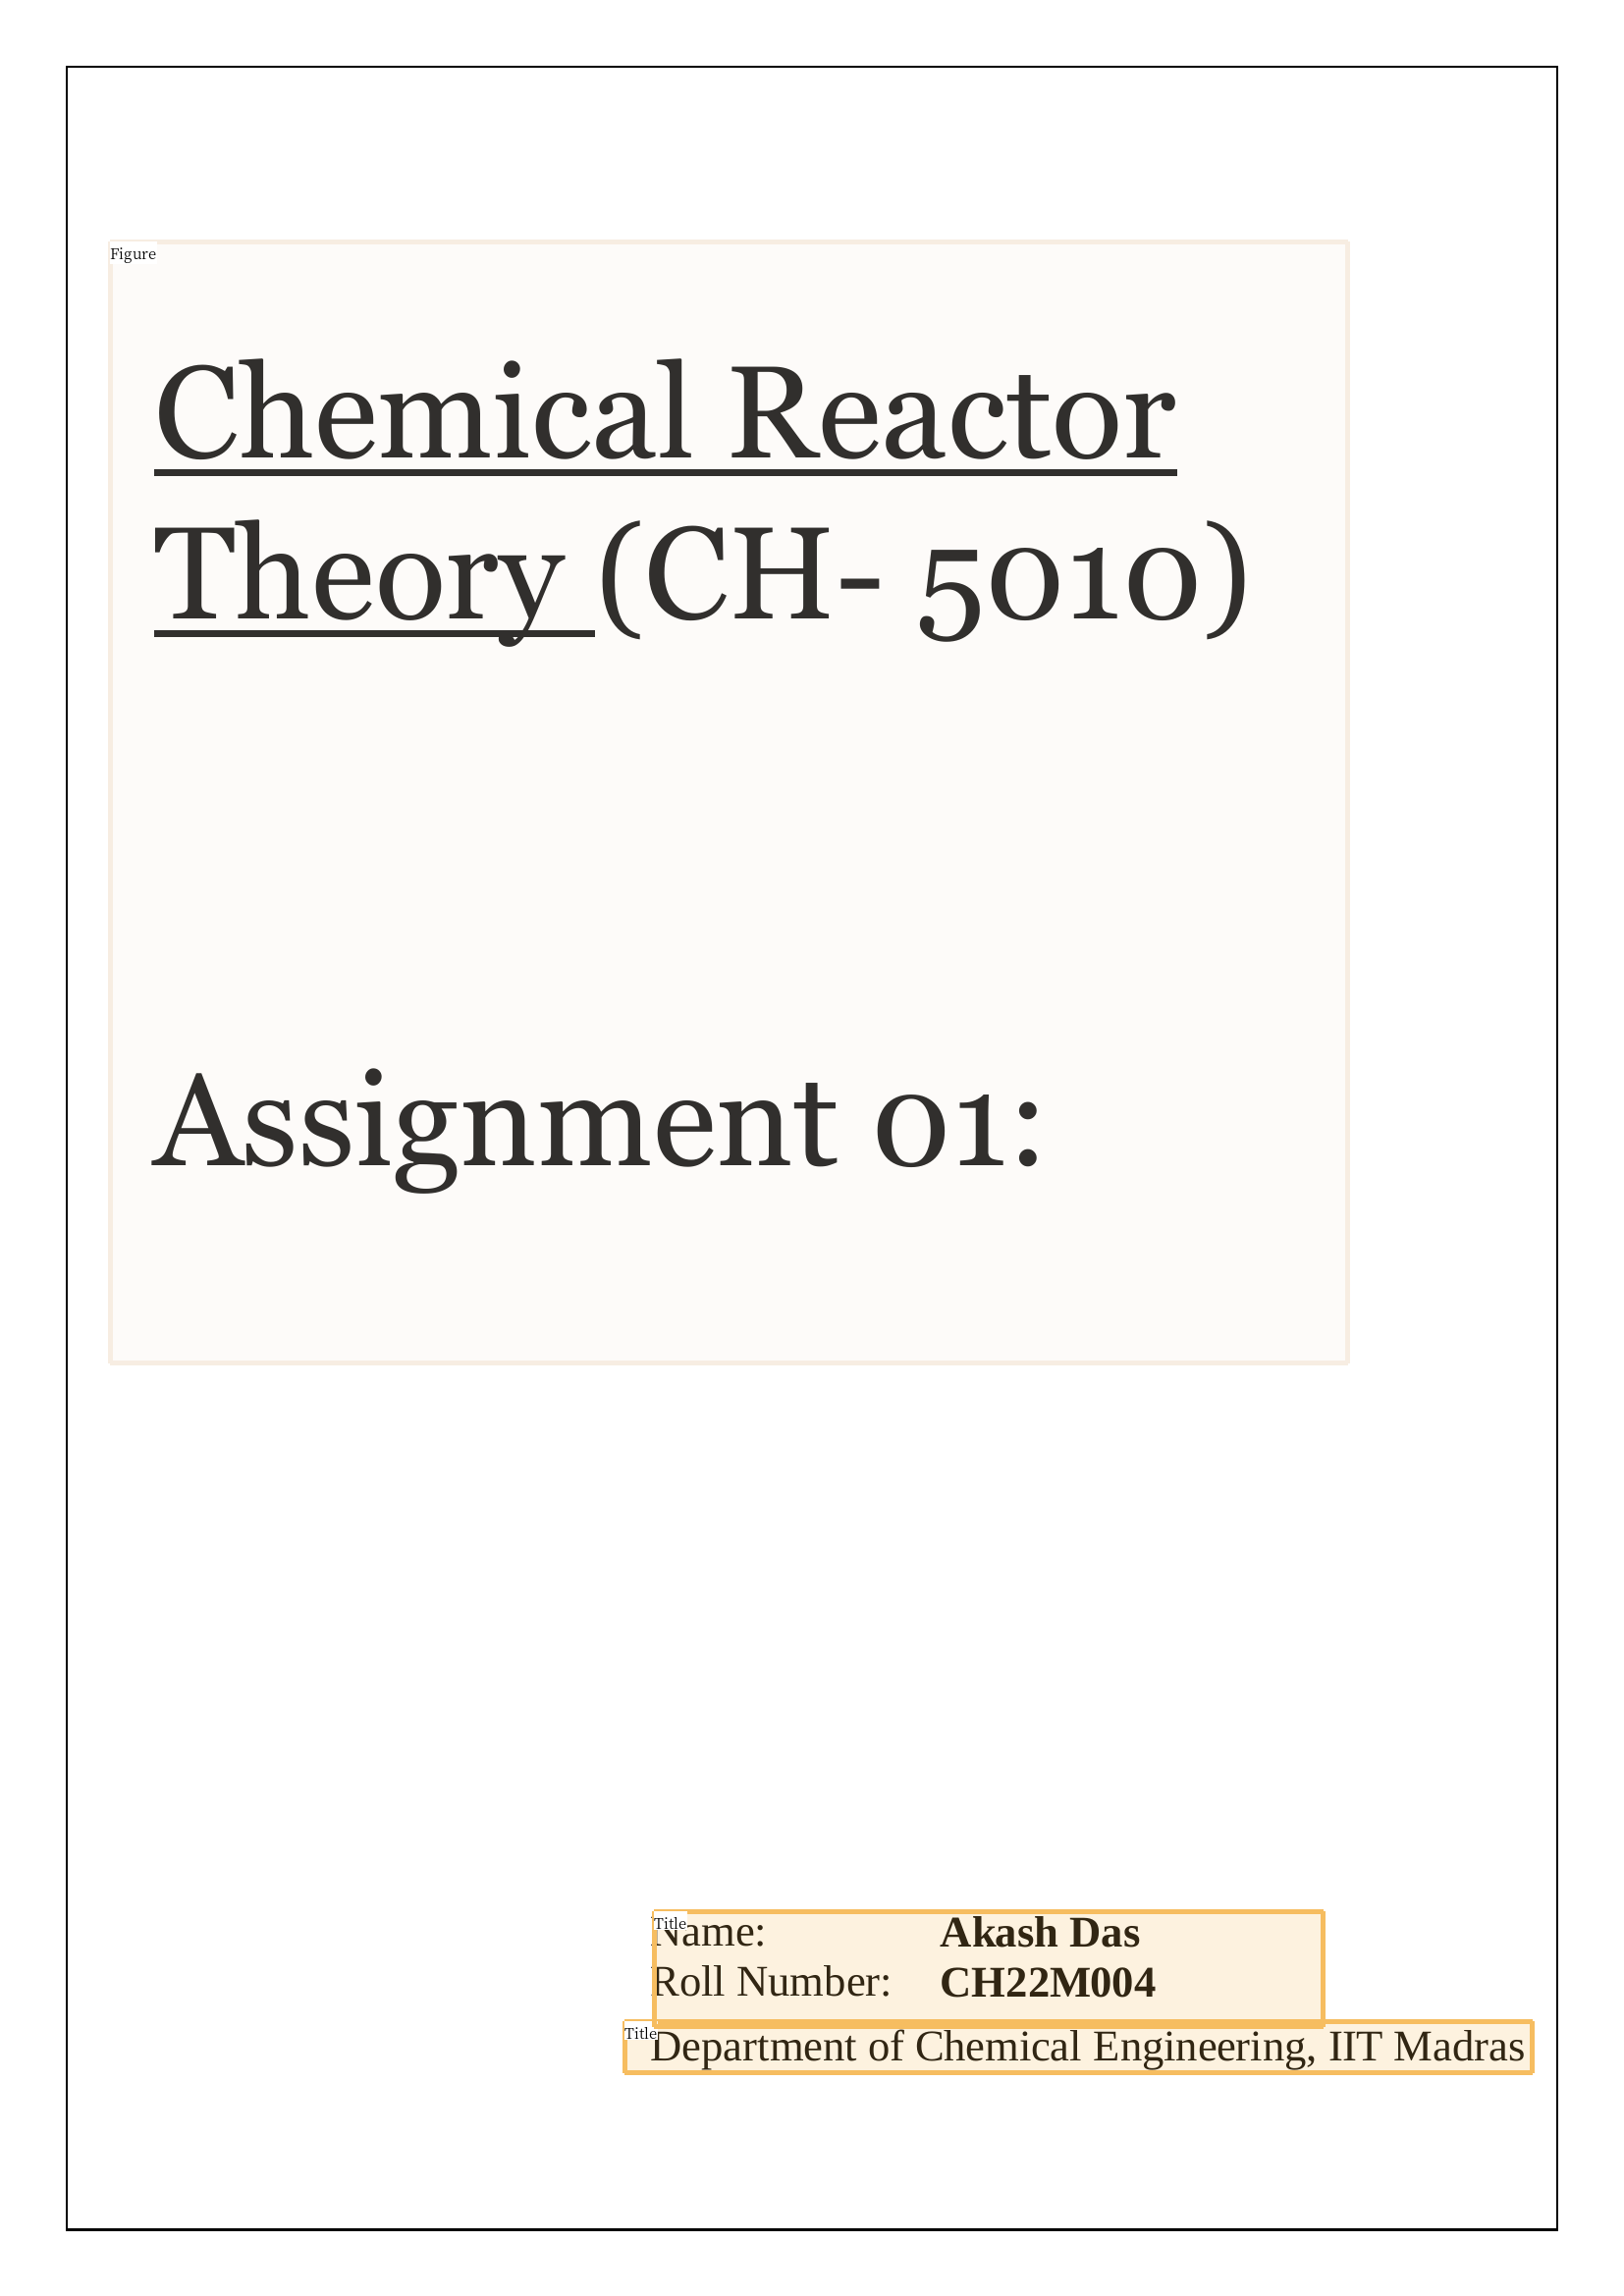

In [3]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

layout_result = model.detect(img)

lp.draw_box(img, layout_result,  box_width=5, box_alpha=0.2, show_element_type=True)

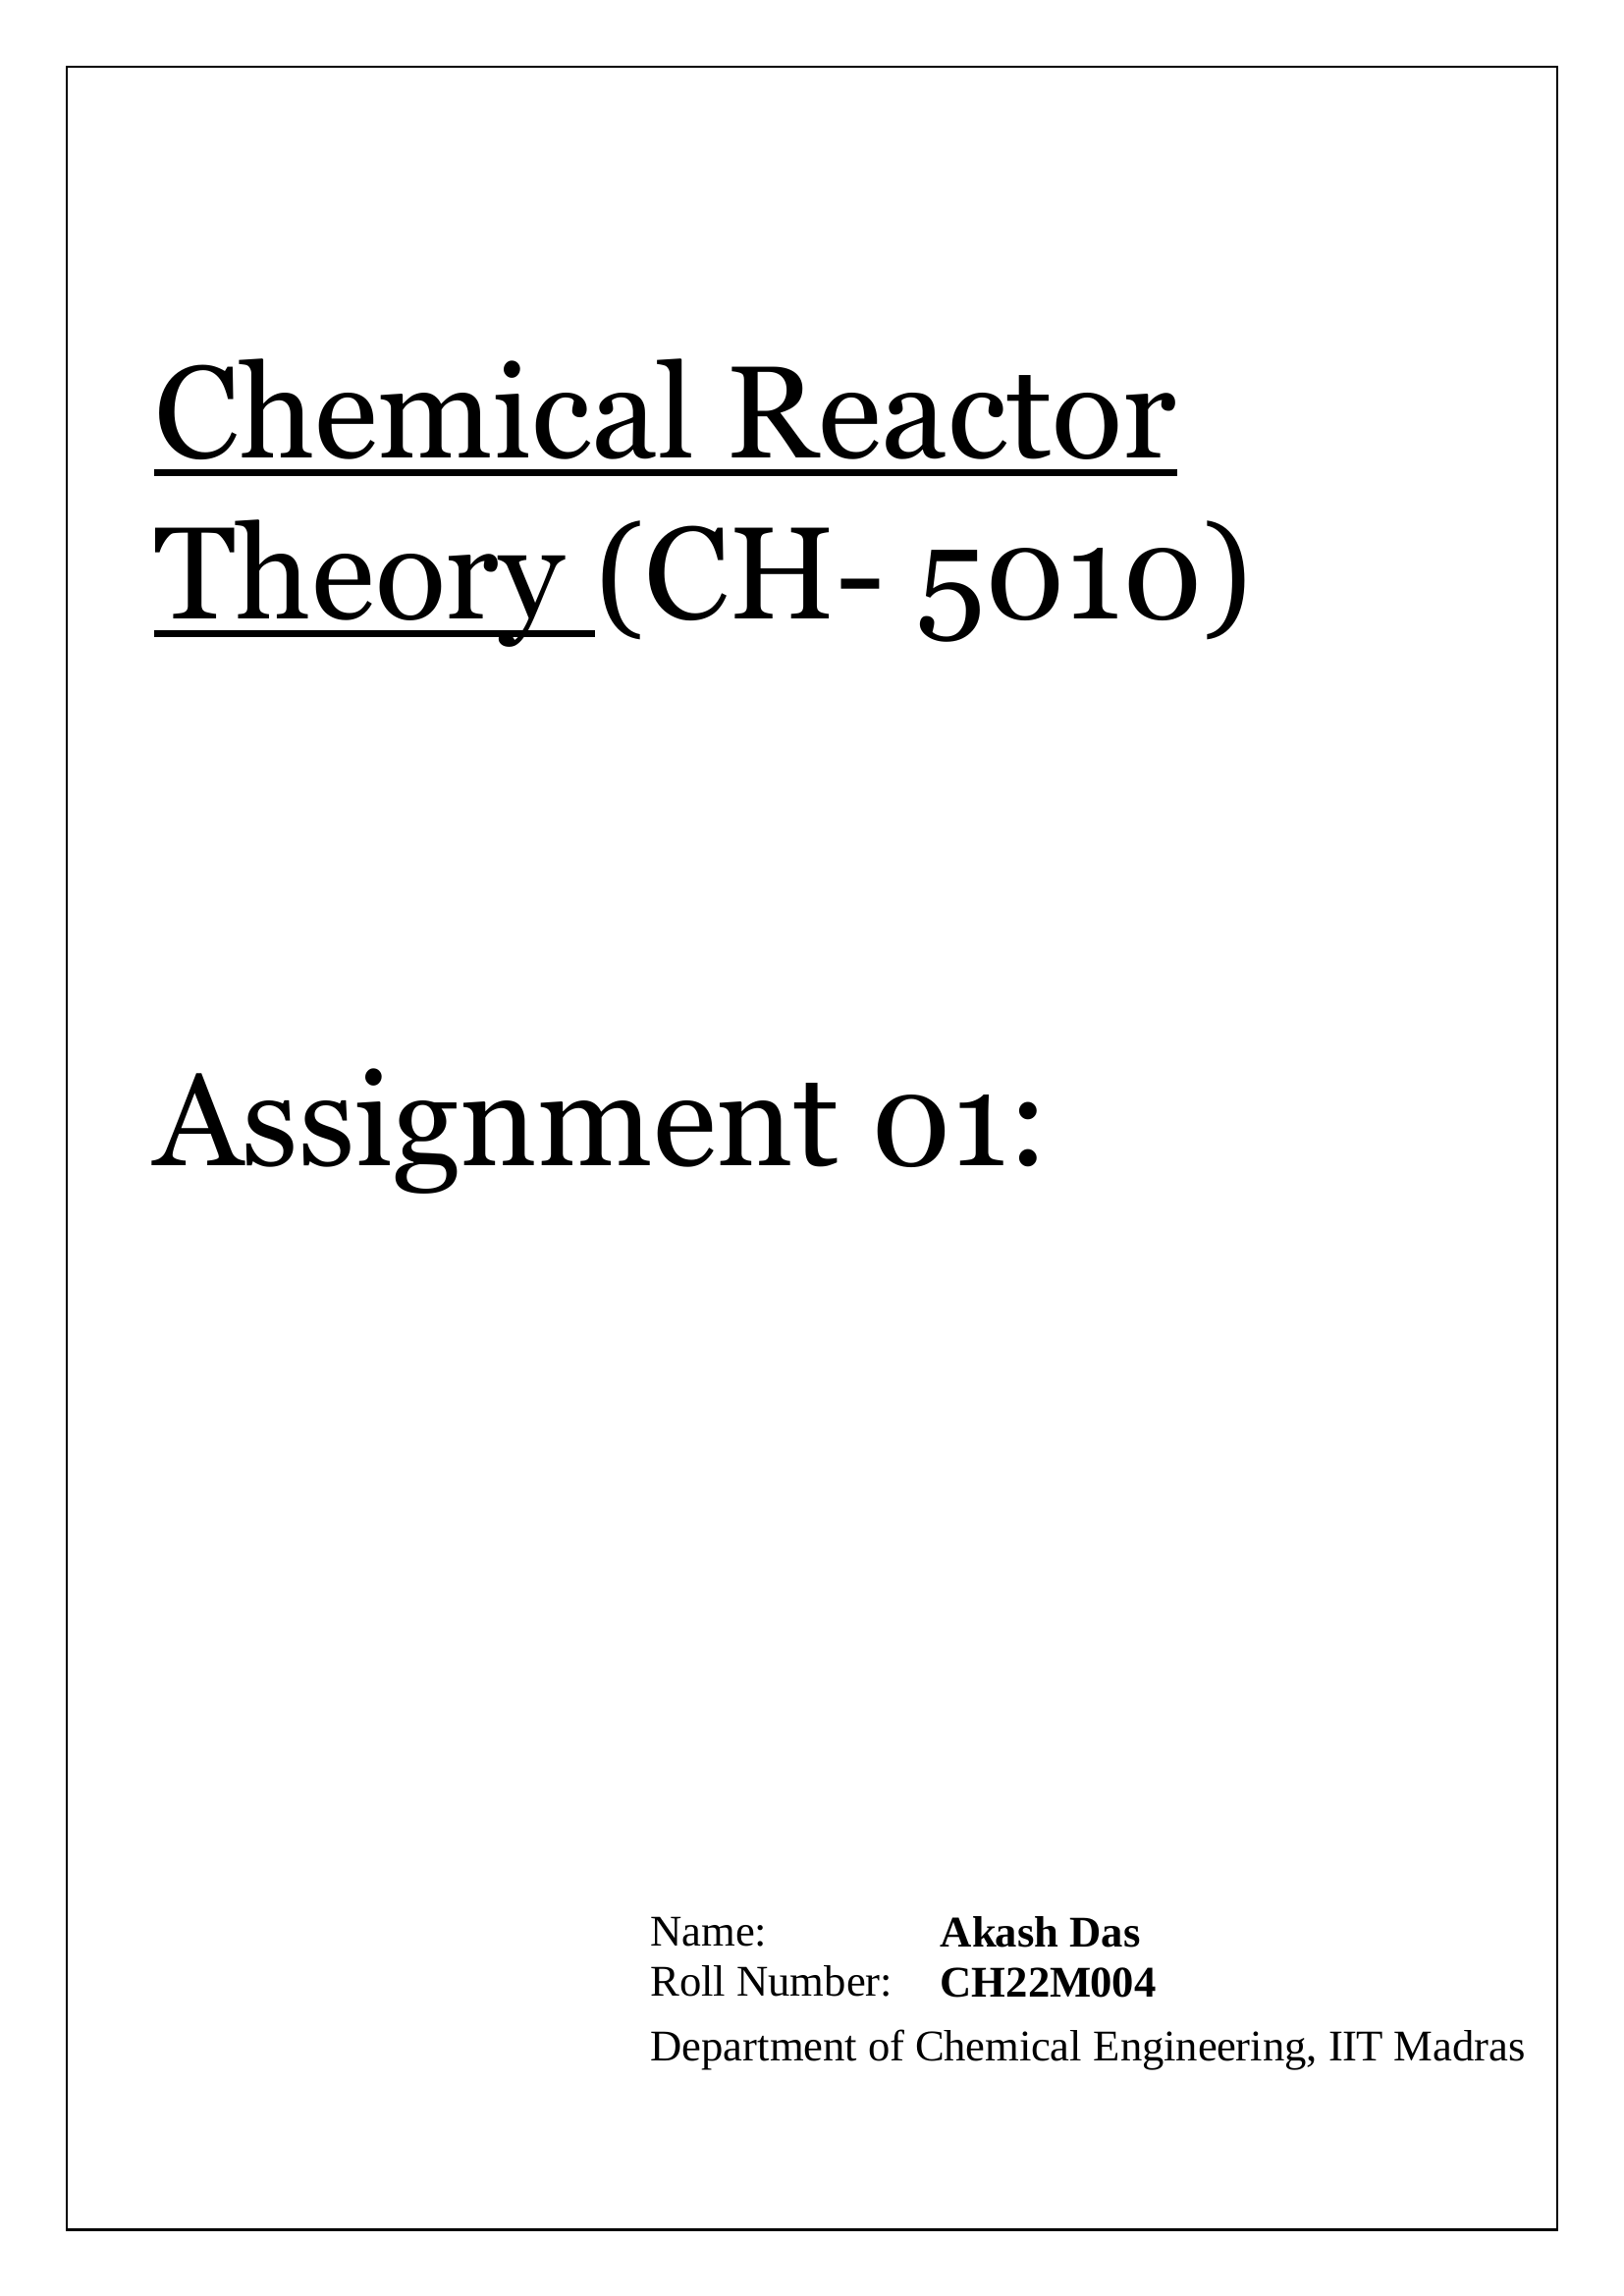

In [4]:
text_blocks = lp.Layout([b for b in layout_result if b.type=='Text'])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [5]:
ocr_agent = lp.TesseractAgent(languages='eng')

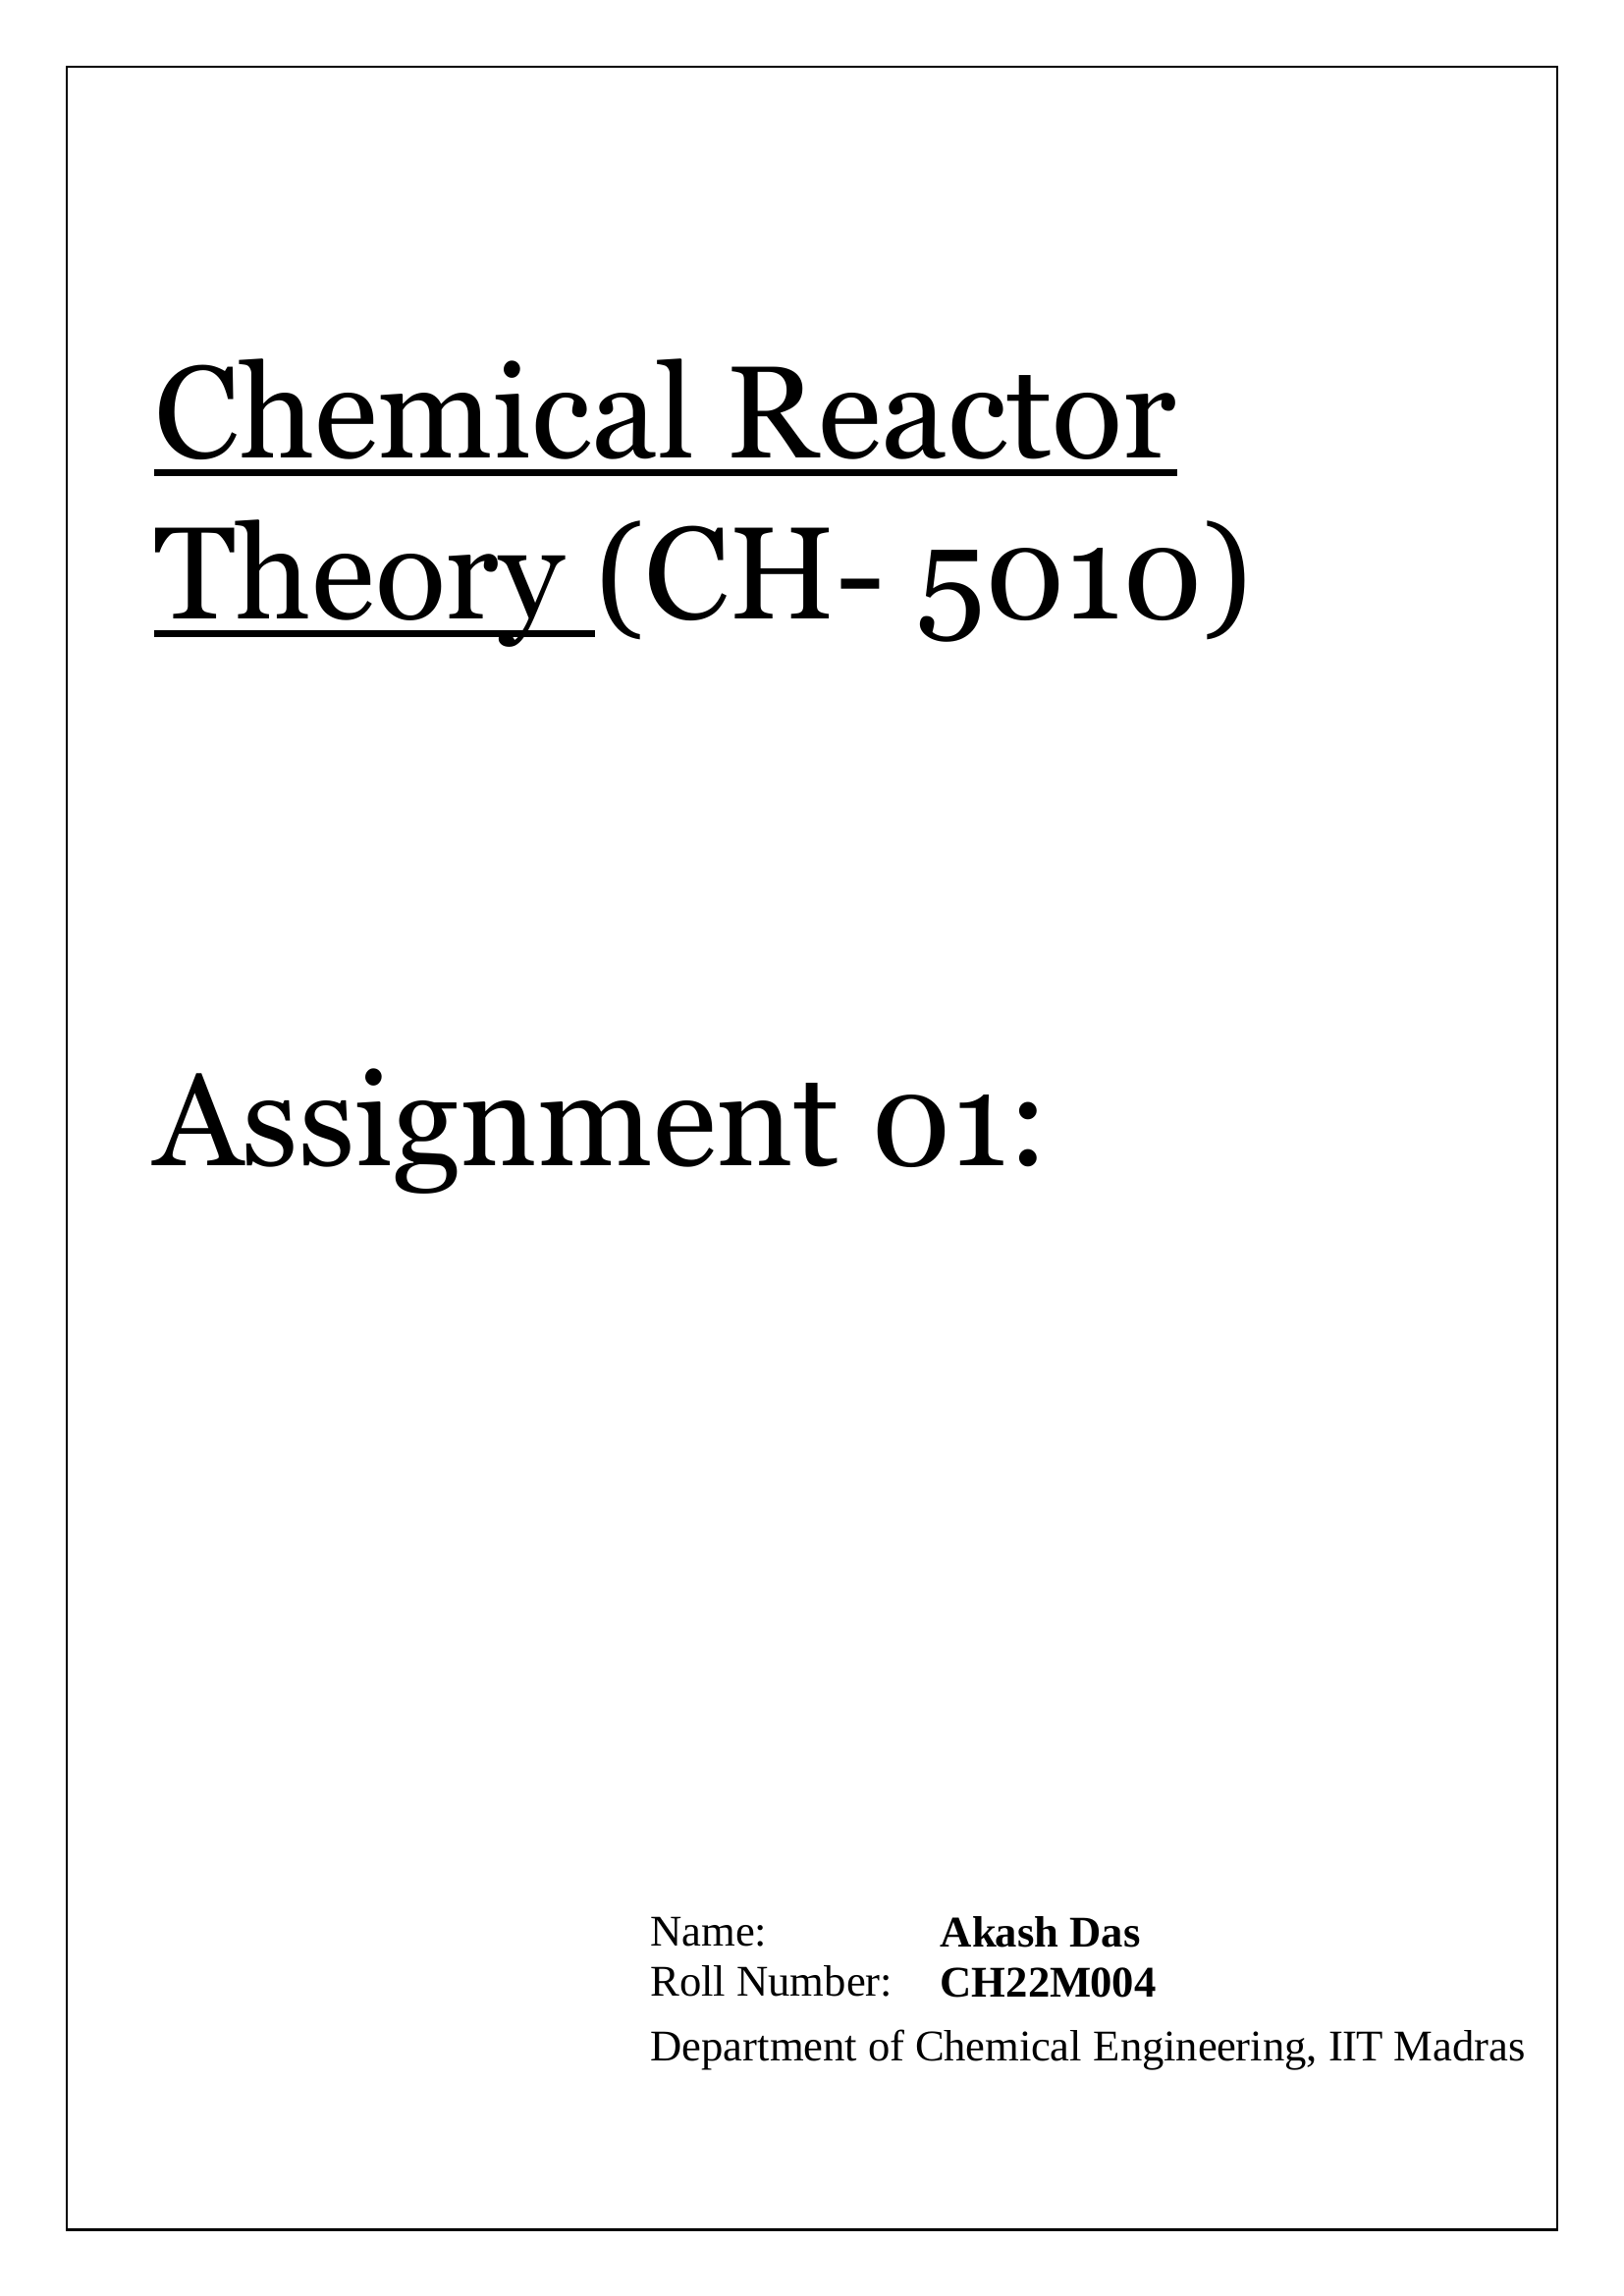

In [6]:
image_width = len(img[0])


left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(img)
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])


right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])


text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [7]:
for block in text_blocks:


    segment_image = (block
                       .pad(left=15, right=15, top=5, bottom=5)
                       .crop_image(img))
    
  
    text = ocr_agent.detect(segment_image)

    
    block.set(text=text, inplace=True)

In [8]:
for txt in text_blocks:
    print(txt.text, end='\n---\n')